In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

In [2]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
data = pd.read_csv('london_flows.csv')
data.info()
data.rename(columns={'station_origin':'Orig','station_destination':'Dest'}, inplace=True)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


,Orig,Dest,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [4]:
data2 = data[data['population'] != 0]
data2 = data2[data2['jobs'] != 0]
data2 = data2[data2['distance'] != 0]

# 最后检查数据信息，确保清理正确
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61413 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Orig        61413 non-null  object 
 1   Dest        61413 non-null  object 
 2   flows       61413 non-null  int64  
 3   population  61413 non-null  int64  
 4   jobs        61413 non-null  int64  
 5   distance    61413 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


In [5]:
data2['Oi1_origpop'] = data2['population']
# 终点的工作岗位也在原始数据集中，我们同样可以直接赋值
data2['Dj1_destjob'] = data2['jobs']
data2.head()

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428


In [6]:
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well
#现在，我们可以创建一个数据透视表，将配对列表转化为矩阵，并计算边际值
datasubmat = pd.pivot_table(data2, values ="flows", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
datasubmat

/tmp/ipykernel_3612/676905000.py:3: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat = pd.pivot_table(data2, values ="flows", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/676905000.py:3: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat = pd.pivot_table(data2, values ="flows", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/676905000.py:3: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat = pd.pivot_

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [7]:
#remove intraflows消除内部流
data2 = data2[data2["Orig"] != data2["Dest"]]

In [8]:
#take the variables and produce logarithms of them对变量进行对数运算
x_variables = ["Dj1_destjob", "distance"]
log_x_vars = []
for x in x_variables:
    data2[f"log_{x}"] = np.log(data2[x])
    log_x_vars.append(f"log_{x}")

In [9]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274
...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832


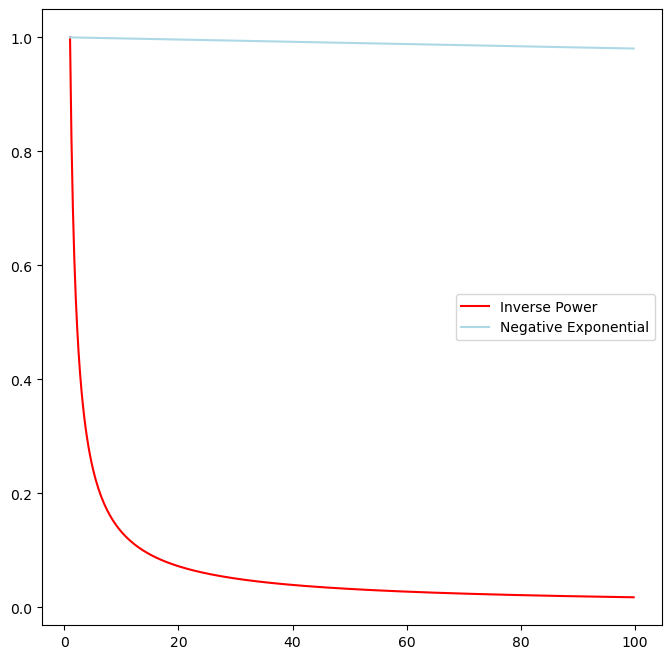

In [10]:
# Now let's consider some model tweaks.现在，让我们来考虑一些模型调整。
# Starting with distance decay.从距离衰减开始
# Let's graph the distance decay parameters to get a feel for how they work.让我们绘制距离衰减参数图，了解它们是如何工作的
xs = np.arange(1.0,100.0,0.25)
# inverse square power反平方幂
y_inv_power = np.power(xs,-0.8781)
# negative exponential, beta = 0.3负指数，β = 0.3
y_neg_exp_point3 = np.exp(-0.0002*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,8))
ax.plot(xs,y_inv_power, label = "Inverse Power", color = "red")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential', color = "lightblue")
ax.legend();
plt.savefig('figure/Figure 10. Comparison of negative power law .png')

In [11]:
#create the formula 计算负指数衰减的模型
formula = 'flows ~ Orig + log_Dj1_destjob + distance -1'

#run the regression进行回归
prodsim_exp = smf.glm(formula = formula, 
                  data=data2, 
                  family=sm.families.Poisson()).fit()

print(prodsim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Sun, 21 Apr 2024   Deviance:                   1.6477e+06
Time:                        17:18:54   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Orig[A

In [12]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(data2.groupby(["Orig"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
data2 = data2.merge(O_i, on = "Orig", how = "left" )

D_j = pd.DataFrame(data2.groupby(["Dest"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
data2 = data2.merge(D_j, on = "Dest", how = "left" )
#这段代码是用Python中的pandas库对一个DataFrame（假设名为cdatasub）进行操作，目的是在其中创建两列新的汇总数据：O_i和D_j。这两列分别代表了起点（OrigCodeNew）和终点（DestCodeNew）的总流量。
#计算起点总流量 O_i：
#O_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Total"].agg(np.sum))
#这行代码首先通过groupby对cdatasub按照OrigCodeNew进行分组，然后选取Total列，并使用agg(np.sum)来计算每个分组的总和。计算出的结果是每个起点的总流量（O_i）。结果被转换成一个新的DataFrame O_i。
#O_i.rename(columns={"Total":"O_i"}, inplace = True)
#这行代码将O_i DataFrame中的Total列重命名为O_i。
#cdatasub = cdatasub.merge(O_i, on = "OrigCodeNew", how = "left")
#这行代码将原始的cdatasub DataFrame与O_i DataFrame合并，基于OrigCodeNew列进行匹配。
#how="left"参数确保了原始cdatasub的所有行都被保留，即使它们在O_i中没有匹配项。

#计算终点总流量 D_j：
#D_j = pd.DataFrame(cdatasub.groupby(["DestCodeNew"])["Total"].agg(np.sum))
#类似地，这行代码计算每个终点DestCodeNew的总流量D_j。
#D_j.rename(columns={"Total":"D_j"}, inplace = True)
#将结果DataFrame中的Total列重命名为D_j。
#cdatasub = cdatasub.merge(D_j, on = "DestCodeNew", how = "left")
#最后，将D_j DataFrame合并回cdatasub，以添加每个终点的总流量信息。

/tmp/ipykernel_3612/687859964.py:3: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  O_i = pd.DataFrame(data2.groupby(["Orig"])["flows"].agg(np.sum))
/tmp/ipykernel_3612/687859964.py:7: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  D_j = pd.DataFrame(data2.groupby(["Dest"])["flows"].agg(np.sum))


In [13]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428
...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,7892,3342
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,7892,5487
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,7892,400
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,7892,893


In [14]:
coefs = prodsim_exp.params

In [15]:
# 创建一个包含起点站名和对应 alpha_i 系数的 DataFrame
# 假设起点站名前缀为 'Orig['
alpha_i_df = coefs[coefs.index.str.startswith('Orig')].reset_index()
alpha_i_df.columns = ['Orig', 'alpha_i']

In [16]:
alpha_i_df.head()

,Orig,alpha_i
0,Orig[Abbey Road],-2.914322
1,Orig[Acton Central],-1.162092
2,Orig[Acton Town],-1.613081
3,Orig[Aldgate],-2.943047
4,Orig[Aldgate East],-2.854752


In [17]:
# 修正起点站名，以便与 data2 中的起点站名匹配
# 原始字符串用法来正确处理正则表达式的特殊字符
alpha_i_df['Orig'] = alpha_i_df['Orig'].str.replace(r'Orig\[', '').str.replace(r'\]', '')
# 替换 'Orig[', ']' 以及其他不需要的字符
alpha_i_df['Orig'] = alpha_i_df['Orig'].str.replace('Orig[', '').str.replace(']', '')

In [18]:
alpha_i_df.head()

,Orig,alpha_i
0,Abbey Road,-2.914322
1,Acton Central,-1.162092
2,Acton Town,-1.613081
3,Aldgate,-2.943047
4,Aldgate East,-2.854752


In [19]:
# 将 alpha_i 系数合并到 data2 数据集
data2 = pd.merge(data2, alpha_i_df, on='Orig', how='left')
# 检查合并
data2.head()

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549,-2.914322
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442,-2.914322
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665,-2.914322
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772,-2.914322
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428,-2.914322


In [20]:
#set up some variables to hold our parameter values in from the previous model设置一些变量来保存上一个模型的参数值
alpha = prodsim_exp.params[:-2]
gamma = prodsim_exp.params[-2]
beta = -prodsim_exp.params[-1]
print(alpha)
print('The Gamma parameter:' , gamma)
print('The Beta parameter:' , beta)

Orig[Abbey Road]         -2.914322
Orig[Acton Central]      -1.162092
Orig[Acton Town]         -1.613081
Orig[Aldgate]            -2.943047
Orig[Aldgate East]       -2.854752
                            ...   
Orig[Wood Street]        -0.942621
Orig[Woodford]           -0.633605
Orig[Woodgrange Park]    -0.896422
Orig[Woodside Park]      -1.149110
Orig[Woolwich Arsenal]    0.518041
Length: 398, dtype: float64
The Gamma parameter: 0.7552215895685621
The Beta parameter: 0.00015316619346317266


/tmp/ipykernel_3612/2868317839.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodsim_exp.params[-2]
/tmp/ipykernel_3612/2868317839.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodsim_exp.params[-1]


In [21]:
# Calculate traffic forecasts for each site
# 假设 K, gamma, beta 是已经定义的参数
data2["prodsimEst1"] = np.exp(data2['alpha_i']
                                    + gamma*data2["log_Dj1_destjob"]
                                    - beta*data2["distance"])

In [22]:
data2.head(10)

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j,alpha_i,prodsimEst1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549,-2.914322,77.685360
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442,-2.914322,1.465951
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665,-2.914322,4.121373
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772,-2.914322,99.484532
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428,-2.914322,56.125688
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208,7.096721,8.807842,599,1208,-2.914322,4.141812
6,Abbey Road,Custom House,0,599,845,3824.855630,599,845,6.739337,8.249276,599,845,-2.914322,4.901455
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,599,1748,7.466228,9.048280,599,1748,-2.914322,4.144676
8,Abbey Road,Cyprus,7,599,850,6532.099618,599,850,6.745236,8.784484,599,850,-2.914322,3.252193
9,Abbey Road,Devons Road,1,599,611,3958.324171,599,611,6.415097,8.283576,599,611,-2.914322,3.759238


In [23]:
#round the numbers so that we don't get a half of a person对数字进行四舍五入，这样就不会出现半个人的情况了
data2["prodsimEst1"] = round(data2["prodsimEst1"], 0)
#convert to integers转换为整数
data2["prodsimEst1"] = data2["prodsimEst1"].astype(int)
#check that the sum of these estimates make sense检查这些估计值的总和是否合理
sum(data2["prodsimEst1"])

1541347

In [24]:
#turn it into a little matrix and have a look at your handy work把它变成一个小矩阵，看看你的杰作吧
data2submat1 = data2.pivot_table(values ="prodsimEst1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
data2submat1

/tmp/ipykernel_3612/2898635969.py:2: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  data2submat1 = data2.pivot_table(values ="prodsimEst1", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/2898635969.py:2: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  data2submat1 = data2.pivot_table(values ="prodsimEst1", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/2898635969.py:2: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  data2submat

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100


In [25]:
CalcRSqaured(data2["flows"], data2["prodsimEst1"])

0.46806484435427537

In [26]:
CalcRMSE(data2["flows"], data2["prodsimEst1"])

96.263

使用反幂律Using the inverse power law

In [81]:
#create the formula 计算反幂律衰减的模型
formula = 'flows ~ Orig + log_Dj1_destjob + log_distance -1'
#run the regression进行回归
prodsim_exp_1 = smf.glm(formula = formula, 
                  data=data2, 
                  family=sm.families.Poisson()).fit()

print(prodsim_exp_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sat, 20 Apr 2024   Deviance:                   1.8615e+06
Time:                        21:21:34   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Orig[A

In [28]:
coefs_1 = prodsim_exp_1.params
# 创建一个包含起点站名和对应 alpha_i 系数的 DataFrame
# 假设起点站名前缀为 'Orig['
alpha_i_1_df = coefs_1[coefs_1.index.str.startswith('Orig')].reset_index()
alpha_i_1_df.columns = ['Orig', 'alpha_i_1']
# 修正起点站名，以便与 data2 中的起点站名匹配
# 原始字符串用法来正确处理正则表达式的特殊字符
alpha_i_1_df['Orig'] = alpha_i_1_df['Orig'].str.replace(r'Orig\[', '').str.replace(r'\]', '')
# 替换 'Orig[', ']' 以及其他不需要的字符
alpha_i_1_df['Orig'] = alpha_i_1_df['Orig'].str.replace('Orig[', '').str.replace(']', '')
# 将 alpha_i 系数合并到 data2 数据集
data2 = pd.merge(data2, alpha_i_1_df, on='Orig', how='left')
#set up some variables to hold our parameter values in from the previous model设置一些变量来保存上一个模型的参数值
alpha_1 = prodsim_exp_1.params[:-2]
gamma_1 = prodsim_exp_1.params[-2]
beta_1 = -prodsim_exp_1.params[-1]
print(alpha_1)
print('The Gamma_1 parameter:' , gamma_1)
print('The Beta_1 parameter:' , beta_1)
# 检查合并
data2.head()

Orig[Abbey Road]          3.250242
Orig[Acton Central]       5.016902
Orig[Acton Town]          4.562892
Orig[Aldgate]             3.323767
Orig[Aldgate East]        3.457664
                            ...   
Orig[Wood Street]         5.242024
Orig[Woodford]            5.160643
Orig[Woodgrange Park]     5.254667
Orig[Woodside Park]       4.698635
Orig[Woolwich Arsenal]    6.905590
Length: 398, dtype: float64
The Gamma_1 parameter: 0.7686156200124395
The Beta_1 parameter: 0.8781191183724237


/tmp/ipykernel_15345/1559963839.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma_1 = prodsim_exp_1.params[-2]
/tmp/ipykernel_15345/1559963839.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_1 = -prodsim_exp_1.params[-1]


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j,alpha_i,prodsimEst1,alpha_i_1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549,-2.914322,78,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442,-2.914322,1,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665,-2.914322,4,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772,-2.914322,99,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428,-2.914322,56,3.250242


In [29]:
# 计算每个站点的流量预测值
# 假设 K, gamma, beta 是已经定义的参数
data2["prodsimEst1_1"] = np.exp(data2['alpha_i_1']
                                    + gamma_1*data2["log_Dj1_destjob"]
                                    - beta_1*data2["log_distance"])
#round the numbers so that we don't get a half of a person对数字进行四舍五入，这样就不会出现半个人的情况了
data2["prodsimEst1_1"] = round(data2["prodsimEst1_1"], 0)
#convert to integers转换为整数
data2["prodsimEst1_1"] = data2["prodsimEst1_1"].astype(int)
#check that the sum of these estimates make sense检查这些估计值的总和是否合理
sum(data2["prodsimEst1_1"])

1541806

In [30]:
CalcRSqaured(data2["flows"], data2["prodsimEst1_1"])

0.3882763950178635

In [31]:
CalcRMSE(data2["flows"], data2["prodsimEst1_1"])

102.893

 为什么一种距离衰减比另一种距离衰减更适合数据？ Why is one type of distance attenuation better for data than another?

情景A：step 1.首先，我们根据这些变化的job数量创建一个新变量Scenario A: STEP 1. First, we create a new variable based on the number of these changing jobs

In [27]:
def new_job(row):
    if row["Dest"] == "Canary Wharf":
        val = 1/2 * row['Dj1_destjob']
    else:
        val = row["Dj1_destjob"]
    return val
data2["Dj2_destJobsScenarioA"] = data2.apply(new_job, axis =1)
data2.head(10)

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j,alpha_i,prodsimEst1,Dj2_destJobsScenarioA
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549,-2.914322,78,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442,-2.914322,1,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665,-2.914322,4,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772,-2.914322,99,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428,-2.914322,56,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208,7.096721,8.807842,599,1208,-2.914322,4,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,599,845,6.739337,8.249276,599,845,-2.914322,5,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,599,1748,7.466228,9.048280,599,1748,-2.914322,4,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,599,850,6.745236,8.784484,599,850,-2.914322,3,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,599,611,6.415097,8.283576,599,611,-2.914322,4,611.0


step 2提取系数

In [28]:
beta

0.00015316619346317266

STEP 4 Calculate our own equilibrium factor, going back to Equation 1 step 4 计算出我们自己的平衡因子，回到公式1

In [29]:
#calculate some new wj^alpha and d_ij^beta values
Dj1_gamma = data2["Dj1_destjob"]**gamma
# dist_beta = data["distance"]**-beta
dist_beta = np.exp(data2['distance']*-beta)
#calcualte the first stage of the Ai values
data2["Ai1"] = Dj1_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
data2 = data2.merge(A_i, left_on="Orig", right_index=True, how="left")

#计算 Dj2_gamma 和 dist_beta：
#Dj2_gamma = cdatasub["Dj2_destsal"]**gamma
#这行代码将 cdatasub 中 Dj2_destsal 列的每个值提升到 gamma 的幂次。gamma 通常是模型中的一个系数，与目的地的吸引力有关。
#dist_beta = cdatasub["Dist"]**(-beta)
#这行代码将 cdatasub 中 Dist 列的每个值提升到 -beta 的幂次。负号表明距离效应是递减的，这是典型的空间衰减效应。

#计算 Ai1 的初步值：
#cdatasub["Ai1"] = Dj2_gamma * dist_beta
#通过将 Dj2_gamma 与 dist_beta 相乘，计算每个起点到每个目的地的交互潜力的初步值，存储在新列 Ai1 中。

#A_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Ai1"].agg(np.sum))
#使用 groupby 和 agg(np.sum) 对每个起点（OrigCodeNew）的所有 Ai1 值求和，得到每个起点的总交互潜力。

#计算平衡因子 A_i：
#A_i["Ai1"] = 1/A_i["Ai1"]
#将 A_i 中的每个值取倒数，得到最终的平衡因子 A_i。这个步骤确保了起点的总交互潜力被标准化。

#重命名列并合并到原数据集：

#A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#将列名 Ai1 改为 A_i。
#cdatasub = cdatasub.merge(A_i, left_on="OrigCodeNew", right_index=True, how="left")
#将计算出的 A_i 值合并回原数据集 cdatasub，匹配 OrigCodeNew 列。

/tmp/ipykernel_3612/2251915618.py:8: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))


In [30]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j,alpha_i,prodsimEst1,Dj2_destJobsScenarioA,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549,-2.914322,78,78549.0,1432.231104,0.000091
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442,-2.914322,1,442.0,27.026714,0.000091
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665,-2.914322,4,665.0,75.982904,0.000091
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772,-2.914322,99,29386.0,1834.127323,0.000091
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428,-2.914322,56,15428.0,1034.750388,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,7892,3342,0.518041,99,3342.0,58.874685,0.000213
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,7892,5487,0.518041,295,5487.0,175.878367,0.000213
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,7892,400,0.518041,36,400.0,21.416897,0.000213
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,7892,893,0.518041,125,893.0,74.528041,0.000213


Step 5 Derive an estimate step 5得出估计值

In [31]:
#计算 $A_i$ 值的方法就是这样。现在您有了这些值，将所有值输入方程 1 并生成一些估计值就非常简单了...prodsimest2是公式4转换为公式1后的估计值
#to check everything works, recreate the original estimates检查一切正常，重新创建原始估算
data2["prodsimest2"] = data2["A_i"]*data2["O_i"]*Dj1_gamma*dist_beta
#round
data2["prodsimest2"] = round(data2["prodsimest2"])
#check
data2[["prodsimEst1", "prodsimest2"]]

,prodsimEst1,prodsimest2
0,78,78.0
1,1,1.0
2,4,4.0
3,99,99.0
4,56,56.0
...,...,...
61408,99,99.0
61409,295,295.0
61410,36,36.0
61411,125,125.0


STEP 6 Continue with some new estimates and keep the constraints. Remember, though, that $A_i$ needs to be recalculated each time you want to create a new set of estimates. step 6继续使用一些新的估计值，并保留约束条件。不过请记住，每次要创建一组新的估计值时，都需要重新计算 $A_i$。

In [32]:
#calculate some new wj^alpha and d_ij^beta values 计算情景a情况下的gamma和beta
Dj2_gamma = data2["Dj2_destJobsScenarioA"]**gamma
#calcualte the first stage of the Ai values
data2["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
data2 = data2.merge(A_i, left_on="Orig", right_index=True, how="left")

/tmp/ipykernel_3612/3427310336.py:6: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))


In [33]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j,alpha_i,prodsimEst1,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549,-2.914322,78,78549.0,1432.231104,0.000091,78.0,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442,-2.914322,1,442.0,27.026714,0.000091,1.0,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665,-2.914322,4,665.0,75.982904,0.000091,4.0,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772,-2.914322,99,29386.0,1086.638601,0.000091,99.0,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428,-2.914322,56,15428.0,1034.750388,0.000091,56.0,0.000097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,7892,3342,0.518041,99,3342.0,58.874685,0.000213,99.0,0.000230
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,7892,5487,0.518041,295,5487.0,175.878367,0.000213,295.0,0.000230
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,7892,400,0.518041,36,400.0,21.416897,0.000213,36.0,0.000230
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,7892,893,0.518041,125,893.0,74.528041,0.000213,125.0,0.000230


In [ ]:
#Now we have some new $A_i$'s, let's generate some new scenario flow estimates...现在我们有了一些新的 $A_i$，让我们生成一些新的情景流量估计值...

In [34]:
#to check everything works, recreate the original estimates检查一切正常，重新创建原始估算
data2["prodsimEst3"] = data2["A_i2"]*data2["O_i"]*Dj2_gamma*dist_beta
#round
data2["prodsimEst3"] = round(data2["prodsimEst3"])

In [35]:
datasubmat2 = data2.pivot_table(values ="prodsimEst3", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
datasubmat2

/tmp/ipykernel_3612/2816798793.py:1: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat2 = data2.pivot_table(values ="prodsimEst3", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/2816798793.py:1: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat2 = data2.pivot_table(values ="prodsimEst3", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/2816798793.py:1: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat2 =

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


In [36]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,O_i,D_j,alpha_i,prodsimEst1,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2,prodsimEst3
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,599,78549,-2.914322,78,78549.0,1432.231104,0.000091,78.0,0.000097,83.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,599,442,-2.914322,1,442.0,27.026714,0.000091,1.0,0.000097,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,599,665,-2.914322,4,665.0,75.982904,0.000091,4.0,0.000097,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,599,58772,-2.914322,99,29386.0,1086.638601,0.000091,99.0,0.000097,63.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,599,15428,-2.914322,56,15428.0,1034.750388,0.000091,56.0,0.000097,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,7892,3342,0.518041,99,3342.0,58.874685,0.000213,99.0,0.000230,107.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,7892,5487,0.518041,295,5487.0,175.878367,0.000213,295.0,0.000230,320.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,7892,400,0.518041,36,400.0,21.416897,0.000213,36.0,0.000230,39.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,7892,893,0.518041,125,893.0,74.528041,0.000213,125.0,0.000230,135.0


In [37]:
# Calculate descriptive statistics for 'prodsimEst2'
stats_prodsimEst2 = data2['prodsimest2'].describe()
stats_prodsimEst2['sum'] = data2['prodsimest2'].sum()

# Calculate descriptive statistics for 'prodsimEst3'
stats_prodsimEst3 = data2['prodsimEst3'].describe()
stats_prodsimEst3['sum'] = data2['prodsimEst3'].sum()

# Combine the statistics into a DataFrame
combined_stats = pd.DataFrame({'prodsimest2': stats_prodsimEst2, 'prodsimEst3': stats_prodsimEst3})


combined_stats_formatted = combined_stats.applymap('{:.0f}'.format)

combined_stats_formatted


/tmp/ipykernel_3612/1391067907.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_stats_formatted = combined_stats.applymap('{:.0f}'.format)


,prodsimest2,prodsimEst3
count,61413,61413
mean,25,25
std,82,80
min,0,0
25%,1,1
50%,6,6
75%,20,20
max,3686,3717
sum,1541347,1541397


情景B

In [38]:
beta

0.00015316619346317266

In [39]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = data2["jobs"]**gamma
beta = beta * 1.5
dist_beta = np.exp(data2['distance']*-beta)
#calcualte the first stage of the Ai values
data2["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i3"}, inplace=True)
#and write the A_i values back into the dataframe
data2 = data2.merge(A_i, left_on="Orig", right_index=True, how="left")
data2.head()

/tmp/ipykernel_3612/3083452515.py:8: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,...,D_j,alpha_i,prodsimEst1,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2,prodsimEst3,A_i3
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,...,78549,-2.914322,78,78549.0,768.354601,0.000091,78.0,0.000097,83.0,0.000119
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,...,442,-2.914322,1,442.0,14.084773,0.000091,1.0,0.000097,2.0,0.000119
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,...,665,-2.914322,4,665.0,56.904408,0.000091,4.0,0.000097,4.0,0.000119
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,...,58772,-2.914322,99,29386.0,1242.378620,0.000091,99.0,0.000097,63.0,0.000119
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,...,15428,-2.914322,56,15428.0,872.373508,0.000091,56.0,0.000097,60.0,0.000119


In [40]:
#to check everything works, recreate the original estimates检查一切正常，重新创建原始估算
data2["prodsimEst4"] = data2["A_i3"]*data2["O_i"]*Dj3_gamma*dist_beta
#round
data2["prodsimEst4"] = round(data2["prodsimEst4"])
datasubmat3 = data2.pivot_table(values ="prodsimEst4", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
datasubmat3

/tmp/ipykernel_3612/2979796842.py:5: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat3 = data2.pivot_table(values ="prodsimEst4", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/2979796842.py:5: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat3 = data2.pivot_table(values ="prodsimEst4", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/2979796842.py:5: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat3 =

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,8.0,7.0,NaN,20.0,0.0,NaN,10.0,...,9.0,2.0,1.0,26.0,NaN,0.0,NaN,0.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,47.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,51.0,NaN,NaN,0.0,0.0,NaN,30.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,36.0,50.0,NaN,NaN,NaN,NaN,22.0,...,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,1.0,16.0,15.0,NaN,0.0,NaN,NaN,32.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3089.0


In [41]:
data2.head()

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,...,alpha_i,prodsimEst1,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2,prodsimEst3,A_i3,prodsimEst4
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,...,-2.914322,78,78549.0,768.354601,0.000091,78.0,0.000097,83.0,0.000119,55.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,...,-2.914322,1,442.0,14.084773,0.000091,1.0,0.000097,2.0,0.000119,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,...,-2.914322,4,665.0,56.904408,0.000091,4.0,0.000097,4.0,0.000119,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,...,-2.914322,99,29386.0,1242.378620,0.000091,99.0,0.000097,63.0,0.000119,89.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,...,-2.914322,56,15428.0,872.373508,0.000091,56.0,0.000097,60.0,0.000119,62.0


In [42]:
beta = -prodsim_exp.params[-1]
beta

/tmp/ipykernel_3612/1130537467.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodsim_exp.params[-1]


0.00015316619346317266

In [43]:
#calculate some new Dj^gamma and d_ij^beta values
Dj4_gamma = data2["jobs"]**gamma
beta = beta * 4
dist_beta = np.exp(data2['distance']*-beta)
#calcualte the first stage of the Ai values
data2["Ai1"] = Dj4_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
data2 = data2.merge(A_i, left_on="Orig", right_index=True, how="left")
data2.head()

/tmp/ipykernel_3612/4105186886.py:8: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(data2.groupby(["Orig"])["Ai1"].agg(np.sum))


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,...,prodsimEst1,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2,prodsimEst3,A_i3,prodsimEst4,A_i4
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,...,78,78549.0,34.143235,0.000091,78.0,0.000097,83.0,0.000119,55.0,0.000294
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,...,1,442.0,0.541418,0.000091,1.0,0.000097,2.0,0.000119,1.0,0.000294
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,...,4,665.0,13.405901,0.000091,4.0,0.000097,4.0,0.000119,4.0,0.000294
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,...,99,29386.0,177.164382,0.000091,99.0,0.000097,63.0,0.000119,89.0,0.000294
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,...,56,15428.0,371.566731,0.000091,56.0,0.000097,60.0,0.000119,62.0,0.000294


In [44]:
#to check everything works, recreate the original estimates检查一切正常，重新创建原始估算
data2["prodsimEst5"] = data2["A_i4"]*data2["O_i"]*Dj4_gamma*dist_beta
#round
data2["prodsimEst5"] = round(data2["prodsimEst5"])
datasubmat4 = data2.pivot_table(values ="prodsimEst5", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
datasubmat4

/tmp/ipykernel_3612/1913824922.py:5: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat4 = data2.pivot_table(values ="prodsimEst5", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/1913824922.py:5: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat4 = data2.pivot_table(values ="prodsimEst5", index="Orig", columns = "Dest",
/tmp/ipykernel_3612/1913824922.py:5: FutureWarning: The provided callable <function sum at 0x7f11701b20c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  datasubmat4 =

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,601.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,27.0,0.0,NaN,0.0,...,0.0,0.0,0.0,21.0,NaN,0.0,NaN,0.0,NaN,3736.0
Aldgate,NaN,NaN,0.0,NaN,82.0,NaN,NaN,0.0,NaN,23.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2873.0
Aldgate East,NaN,NaN,0.0,94.0,NaN,NaN,0.0,0.0,NaN,23.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,2.0,4.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4864.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,2.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3087.0


In [45]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,...,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2,prodsimEst3,A_i3,prodsimEst4,A_i4,prodsimEst5
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,...,78549.0,34.143235,0.000091,78.0,0.000097,83.0,0.000119,55.0,0.000294,6.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,...,442.0,0.541418,0.000091,1.0,0.000097,2.0,0.000119,1.0,0.000294,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,...,665.0,13.405901,0.000091,4.0,0.000097,4.0,0.000119,4.0,0.000294,2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,...,29386.0,177.164382,0.000091,99.0,0.000097,63.0,0.000119,89.0,0.000294,31.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,...,15428.0,371.566731,0.000091,56.0,0.000097,60.0,0.000119,62.0,0.000294,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,...,3342.0,0.124594,0.000213,99.0,0.000230,107.0,0.000437,73.0,0.006937,7.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,...,5487.0,3.226786,0.000213,295.0,0.000230,320.0,0.000437,311.0,0.006937,177.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,...,400.0,0.267689,0.000213,36.0,0.000230,39.0,0.000437,36.0,0.006937,15.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,...,893.0,6.362659,0.000213,125.0,0.000230,135.0,0.000437,170.0,0.006937,348.0


分析

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

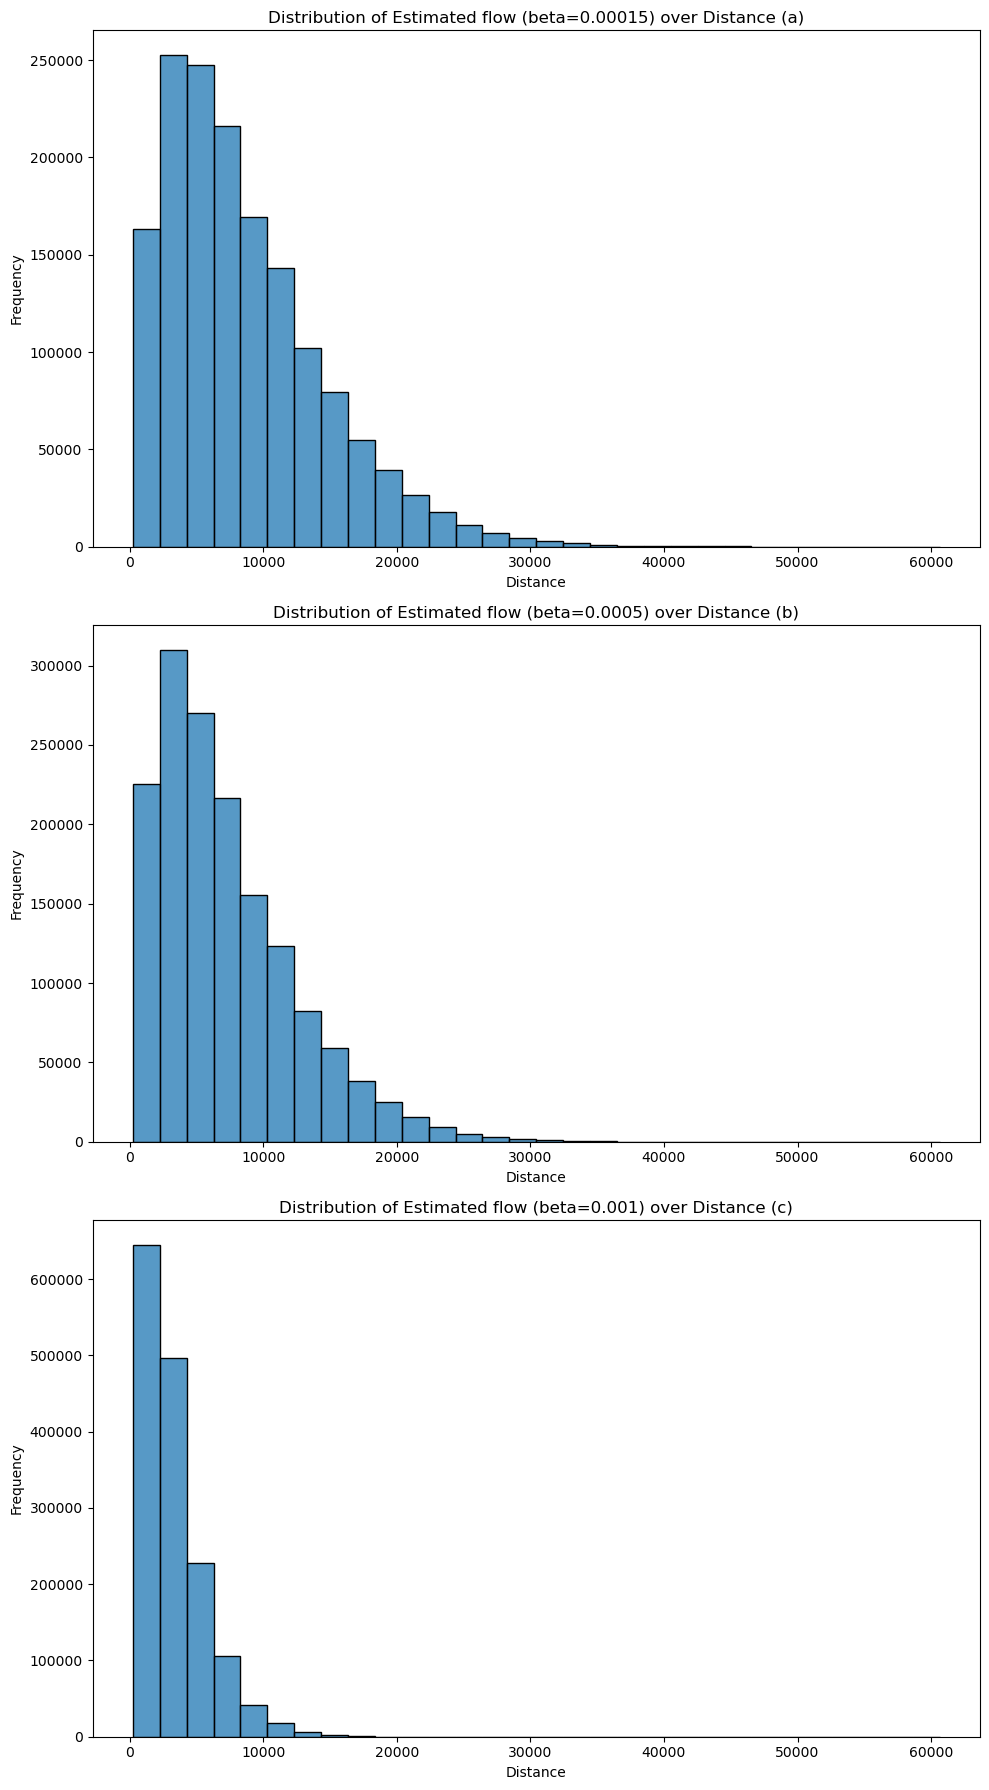

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot for 'prodsimest2'
sns.histplot(data2, x='distance', weights='prodsimest2', bins=30, kde=False, ax=axes[0])
axes[0].set_title('Distribution of Estimated flow (beta=0.00015) over Distance (a)')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Frequency')

# Plot for 'prodsimEst4'
sns.histplot(data2, x='distance', weights='prodsimEst4', bins=30, kde=False, ax=axes[1])
axes[1].set_title('Distribution of Estimated flow (beta=0.0005) over Distance (b)')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Frequency')

# Plot for 'prodsimEst5'
sns.histplot(data2, x='distance', weights='prodsimEst5', bins=30, kde=False, ax=axes[2])
axes[2].set_title('Distribution of Estimated flow (beta=0.001) over Distance (c)')
axes[2].set_xlabel('Distance')
axes[2].set_ylabel('Frequency')

# Adjust layout for better visibility
plt.tight_layout()
plt.savefig('figure/Figure 11. Distribution of inter-site traffic flows over a range of distances.png')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

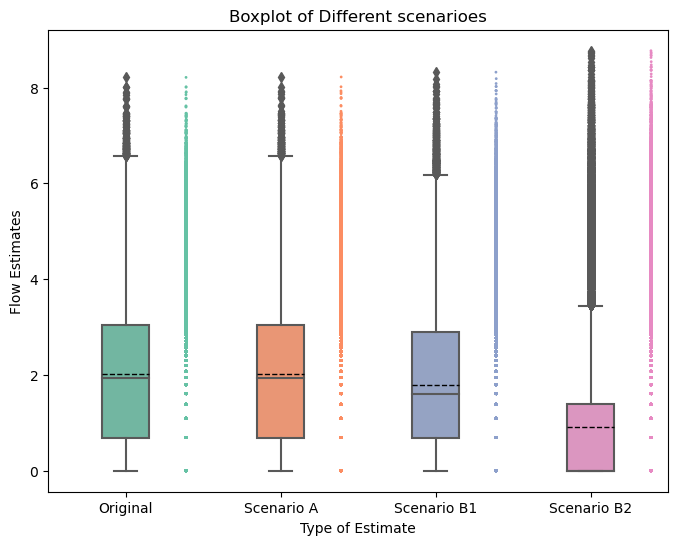

In [47]:
# Assuming data2 is available with the columns as specified
# First, we need to reshape the data so it can be used in a seaborn boxplot for multiple columns
data3 = data2.copy()
data3['prodsimest2'] = np.log(data3['prodsimest2'] + 1)
data3['prodsimEst3'] = np.log(data3['prodsimEst3'] + 1)
data3['prodsimEst4'] = np.log(data3['prodsimEst4'] + 1)
data3['prodsimEst5'] = np.log(data3['prodsimEst5'] + 1)

data_melted = data3.melt(value_vars=['prodsimest2', 'prodsimEst3', 'prodsimEst4', 'prodsimEst5'],
                         var_name='EstimateType', value_name='Flow')

# Mapping old column names to new labels
labels_map = {
    'prodsimest2': 'Original',
    'prodsimEst3': 'Scenario A',
    'prodsimEst4': 'Scenario B1',
    'prodsimEst5': 'Scenario B2'
}
data_melted['EstimateType'] = data_melted['EstimateType'].map(labels_map)

# Now create the boxplot
plt.figure(figsize=(8, 6))
box = sns.boxplot(x='EstimateType', y='Flow', data=data_melted, palette="Set2", width=0.3, showmeans=True,
                  meanline=True, meanprops={'color': 'black', 'linewidth': 1})
# Overlay with a stripplot to show the points
strip = sns.stripplot(x='EstimateType', y='Flow', data=data_melted, palette="Set2", size=2, jitter=0.001)
current_positions = [patch.get_x() for patch in box.artists]
for i,box_artist in enumerate(box.artists):
    # We adjust the position by subtracting 0.2 from the current x position
    box_artist.set_x(current_positions[i] - 1)
    for j in range(6*i, 6*(i+1)):
         line = box.lines[j]
         # We do the same for the related lines (whiskers, caps, fliers)
         line.set_xdata(line.get_xdata() - 5)
# Adjust the positions of the stripplot (right) by increasing the x value
for i,strip in enumerate(strip.collections):
    strip.set_offsets([(x + 0.39, y) for x, y in strip.get_offsets()])

# Set the edgecolor and linewidth for boxplot to match the fill color
for patch in box.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_edgecolor((r, g, b))
    patch.set_linewidth(1)
plt.title('Boxplot of Different scenarioes')
plt.xlabel('Type of Estimate')
plt.ylabel('Flow Estimates')
plt.savefig('figure/Figure 12. Overall distribution of flow values under different scenarios.png')
plt.show()

In [48]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,...,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2,prodsimEst3,A_i3,prodsimEst4,A_i4,prodsimEst5
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,...,78549.0,34.143235,0.000091,78.0,0.000097,83.0,0.000119,55.0,0.000294,6.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,...,442.0,0.541418,0.000091,1.0,0.000097,2.0,0.000119,1.0,0.000294,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,...,665.0,13.405901,0.000091,4.0,0.000097,4.0,0.000119,4.0,0.000294,2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,...,29386.0,177.164382,0.000091,99.0,0.000097,63.0,0.000119,89.0,0.000294,31.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,...,15428.0,371.566731,0.000091,56.0,0.000097,60.0,0.000119,62.0,0.000294,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,...,3342.0,0.124594,0.000213,99.0,0.000230,107.0,0.000437,73.0,0.006937,7.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,...,5487.0,3.226786,0.000213,295.0,0.000230,320.0,0.000437,311.0,0.006937,177.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,...,400.0,0.267689,0.000213,36.0,0.000230,39.0,0.000437,36.0,0.006937,15.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,...,893.0,6.362659,0.000213,125.0,0.000230,135.0,0.000437,170.0,0.006937,348.0


In [49]:
# Calculate descriptive statistics for 'prodsimEst2'
stats_prodsimEst2 = data2['prodsimest2'].describe()
stats_prodsimEst2['sum'] = data2['prodsimest2'].sum()

# Calculate descriptive statistics for 'prodsimEst3'
stats_prodsimEst3 = data2['prodsimEst3'].describe()
stats_prodsimEst3['sum'] = data2['prodsimEst3'].sum()
stats_prodsimEst4 = data2['prodsimEst4'].describe()
stats_prodsimEst4['sum'] = data2['prodsimEst4'].sum()
stats_prodsimEst5 = data2['prodsimEst5'].describe()
stats_prodsimEst5['sum'] = data2['prodsimEst5'].sum()
# Combine the statistics into a DataFrame
combined_stats = pd.DataFrame({'prodsimest2': stats_prodsimEst2, 'prodsimEst3': stats_prodsimEst3, 'prodsimEst4': stats_prodsimEst4, 'prodsimEst5': stats_prodsimEst5})


combined_stats_formatted = combined_stats.applymap('{:.0f}'.format)

combined_stats_formatted

/tmp/ipykernel_3612/2301797396.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_stats_formatted = combined_stats.applymap('{:.0f}'.format)


,prodsimest2,prodsimEst3,prodsimEst4,prodsimEst5
count,61413,61413,61413,61413
mean,25,25,25,25
std,82,80,91,154
min,0,0,0,0
25%,1,1,1,0
50%,6,6,4,0
75%,20,20,17,3
max,3686,3717,4109,6431
sum,1541347,1541397,1540889,1540822


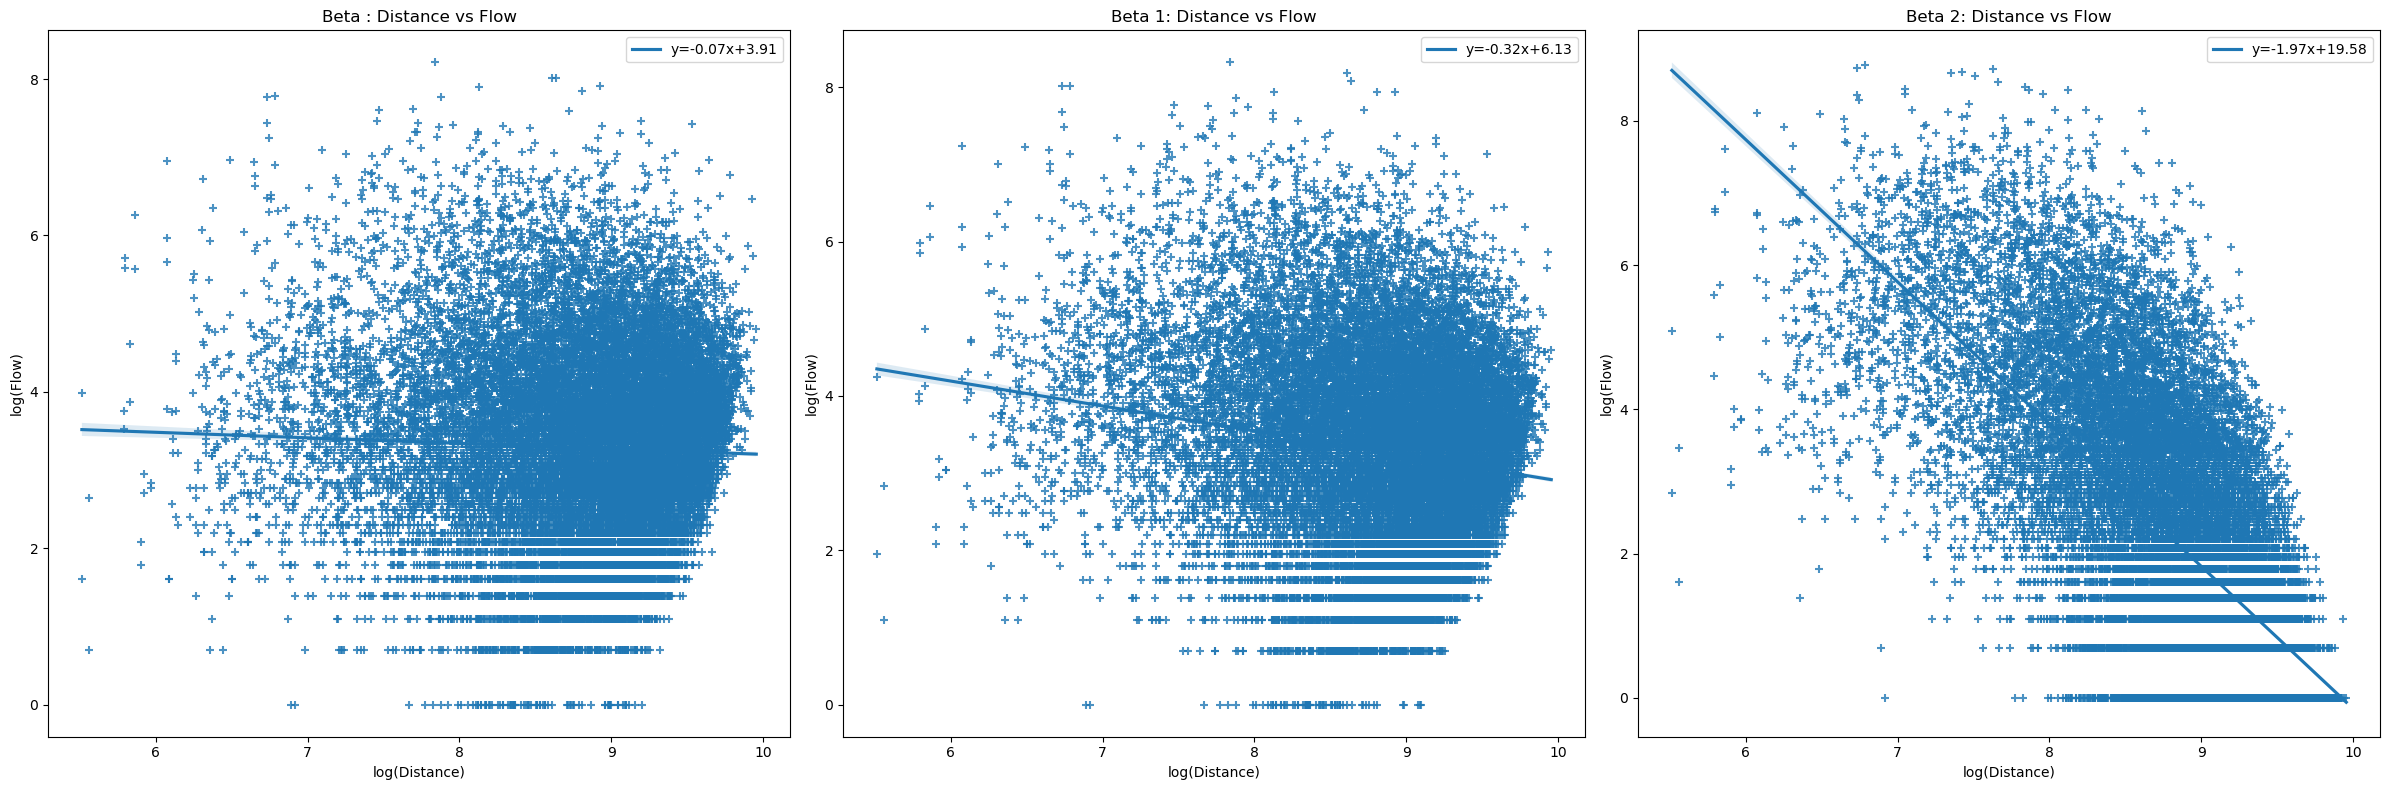

In [50]:
# 预处理：去除任何包含0的行（对距离和所有流量列）
from scipy.stats import linregress
data4 = data2.copy()
data4 = data4[(data4[['distance', 'prodsimEst4', 'prodsimEst5']] != 0).all(axis=1)]

# 对数转换
data4['log_distance'] = np.log(data4['distance'])
data4['log_flow_beta1'] = np.log(data4['prodsimest2'])
data4['log_flow_beta2'] = np.log(data4['prodsimEst4'])
data4['log_flow_beta3'] = np.log(data4['prodsimEst5'])

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(data4['log_distance'], data4['log_flow_beta1'])
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(data4['log_distance'], data4['log_flow_beta2'])
slope3, intercept3, r_value3, p_value3, std_err3 = linregress(data4['log_distance'], data4['log_flow_beta3'])


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

sns.regplot(x='log_distance', y='log_flow_beta1', data=data4, ax=axs[0], marker='+', line_kws={'label':f"y={slope1:.2f}x+{intercept1:.2f}"})
axs[0].set_title('Beta : Distance vs Flow')
axs[0].set_xlabel('log(Distance)')
axs[0].set_ylabel('log(Flow)')
axs[0].legend()
# 绘制第一个图，包含斜率和截距
sns.regplot(x='log_distance', y='log_flow_beta2', data=data4, ax=axs[1], marker='+', line_kws={'label':f"y={slope2:.2f}x+{intercept2:.2f}"})
axs[1].set_title('Beta 1: Distance vs Flow')
axs[1].set_xlabel('log(Distance)')
axs[1].set_ylabel('log(Flow)')
axs[1].legend()

# 绘制第二个图，包含斜率和截距
sns.regplot(x='log_distance', y='log_flow_beta3', data=data4, ax=axs[2], marker='+', line_kws={'label':f"y={slope3:.2f}x+{intercept3:.2f}"})
axs[2].set_title('Beta 2: Distance vs Flow')
axs[2].set_xlabel('log(Distance)')
axs[2].set_ylabel('log(Flow)')
axs[2].legend()



plt.tight_layout()
plt.savefig('figure/Figure 14. Relationship between flow and distance in different scenarios.png')
plt.show()

In [57]:
# Assuming 'data2' is a DataFrame in the current environment
data2.to_csv('data2.csv', index=False)

In [55]:
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,...,Dj2_destJobsScenarioA,Ai1,A_i,prodsimest2,A_i2,prodsimEst3,A_i3,prodsimEst4,A_i4,prodsimEst5
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,...,78549.0,34.143235,0.000091,78.0,0.000097,83.0,0.000119,55.0,0.000294,6.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,...,442.0,0.541418,0.000091,1.0,0.000097,2.0,0.000119,1.0,0.000294,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,...,665.0,13.405901,0.000091,4.0,0.000097,4.0,0.000119,4.0,0.000294,2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,...,29386.0,177.164382,0.000091,99.0,0.000097,63.0,0.000119,89.0,0.000294,31.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,...,15428.0,371.566731,0.000091,56.0,0.000097,60.0,0.000119,62.0,0.000294,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,...,3342.0,0.124594,0.000213,99.0,0.000230,107.0,0.000437,73.0,0.006937,7.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,...,5487.0,3.226786,0.000213,295.0,0.000230,320.0,0.000437,311.0,0.006937,177.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,...,400.0,0.267689,0.000213,36.0,0.000230,39.0,0.000437,36.0,0.006937,15.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,...,893.0,6.362659,0.000213,125.0,0.000230,135.0,0.000437,170.0,0.006937,348.0


In [56]:
data2["SA_change"] = (data2["prodsimEst3"] - data2["prodsimest2"]) 
data2["SB1_change"] = (data2["prodsimEst4"] - data2["prodsimest2"]) 
data2["SB2_change"] = (data2["prodsimEst5"] - data2["prodsimest2"]) 
data2

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Dj1_destjob,log_Dj1_destjob,log_distance,...,prodsimest2,A_i2,prodsimEst3,A_i3,prodsimEst4,A_i4,prodsimEst5,SA_change,SB1_change,SB2_change
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,11.271478,9.003504,...,78.0,0.000097,83.0,0.000119,55.0,0.000294,6.0,5.0,-23.0,-72.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,6.091310,9.049012,...,1.0,0.000097,2.0,0.000119,1.0,0.000294,0.0,1.0,0.0,-1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,6.499787,8.236275,...,4.0,0.000097,4.0,0.000119,4.0,0.000294,2.0,0.0,0.0,-2.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,10.981421,8.534348,...,99.0,0.000097,63.0,0.000119,89.0,0.000294,31.0,-36.0,-10.0,-68.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,9.643939,7.709274,...,56.0,0.000097,60.0,0.000119,62.0,0.000294,66.0,4.0,6.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,8.114325,9.503144,...,99.0,0.000230,107.0,0.000437,73.0,0.006937,7.0,8.0,-26.0,-92.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,8.610137,9.071245,...,295.0,0.000230,320.0,0.000437,311.0,0.006937,177.0,25.0,16.0,-118.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,5.991465,9.162905,...,36.0,0.000230,39.0,0.000437,36.0,0.006937,15.0,3.0,0.0,-21.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,6.794587,8.585832,...,125.0,0.000230,135.0,0.000437,170.0,0.006937,348.0,10.0,45.0,223.0
